In [ ]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

--2024-12-10 04:57:29--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.10.195, 54.231.129.209, 52.217.98.236, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.10.195|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  42.4MB/s    in 6.4s    

2024-12-10 04:57:35 (37.5 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]



In [ ]:
!wget http://images.cocodataset.org/zips/val2017.zip

--2024-12-10 04:57:35--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.9.171, 52.216.92.155, 16.182.100.9, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.9.171|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  31.3MB/s    in 43s     

2024-12-10 04:58:18 (18.2 MB/s) - ‘val2017.zip’ saved [815585330/815585330]



In [ ]:
!unzip val2017.zip

Streaming output truncated to the last 5000 lines.
 extracting: val2017/000000212226.jpg  
 extracting: val2017/000000231527.jpg  
 extracting: val2017/000000578922.jpg  
 extracting: val2017/000000062808.jpg  
 extracting: val2017/000000119038.jpg  
 extracting: val2017/000000114871.jpg  
 extracting: val2017/000000463918.jpg  
 extracting: val2017/000000365745.jpg  
 extracting: val2017/000000320425.jpg  
 extracting: val2017/000000481404.jpg  
 extracting: val2017/000000314294.jpg  
 extracting: val2017/000000335328.jpg  
 extracting: val2017/000000513688.jpg  
 extracting: val2017/000000158548.jpg  
 extracting: val2017/000000132116.jpg  
 extracting: val2017/000000415238.jpg  
 extracting: val2017/000000321333.jpg  
 extracting: val2017/000000081738.jpg  
 extracting: val2017/000000577584.jpg  
 extracting: val2017/000000346905.jpg  
 extracting: val2017/000000433980.jpg  
 extracting: val2017/000000228144.jpg  
 extracting: val2017/000000041872.jpg  
 extracting: val2017/00000011

In [ ]:
!unzip annotations_trainval2017.zip

Archive:  annotations_trainval2017.zip
  inflating: annotations/instances_train2017.json  
  inflating: annotations/instances_val2017.json  
  inflating: annotations/captions_train2017.json  
  inflating: annotations/captions_val2017.json  
  inflating: annotations/person_keypoints_train2017.json  
  inflating: annotations/person_keypoints_val2017.json  


In [ ]:
!pip install pycocotools ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.8/898.8 kB 23.6 MB/s eta 0:00:00


Faster RCNN

In [ ]:
# Import modul dan library yang dibutuhkan
import os  # Untuk operasi sistem file
import torch  # Library utama untuk deep learning
import torchvision  # Library untuk pengolahan data visual
from torchvision import transforms as T  # Modul untuk transformasi data gambar
from torch.utils.data import DataLoader, random_split  # Untuk pemrosesan data batch
from torchvision.models.detection import fasterrcnn_resnet50_fpn  # Model Faster R-CNN
from pycocotools.coco import COCO  # Untuk bekerja dengan dataset COCO
from PIL import Image  # Untuk memproses gambar
import json  # Untuk membaca/menulis file JSON
import random  # Untuk pengacakan data

# Atur device ke GPU jika tersedia, jika tidak, gunakan CPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Definisikan kelas dataset COCO kustom untuk mendeteksi hanya kelas "person"
class CustomCocoDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation_file, transform=None):
        self.root = root  # Lokasi folder gambar
        self.coco = COCO(annotation_file)  # Load file anotasi COCO
        self.ids = list(self.coco.imgs.keys())  # Ambil semua ID gambar
        self.transform = transform  # Transformasi gambar jika diperlukan

    def __getitem__(self, idx):
        img_id = self.ids[idx]  # ID gambar berdasarkan indeks
        img_info = self.coco.loadImgs(img_id)[0]  # Ambil informasi gambar
        path = os.path.join(self.root, img_info['file_name'])  # Lokasi file gambar
        image = Image.open(path).convert("RGB")  # Buka gambar dan ubah ke RGB

        # Ambil anotasi untuk gambar ini
        annotations = self.coco.loadAnns(self.coco.getAnnIds(imgIds=img_id))

        boxes = []  # Untuk menyimpan bounding box
        labels = []  # Untuk menyimpan label
        for ann in annotations:
            # Filter hanya kelas "person" (ID kategori = 1 di COCO)
            if ann['category_id'] == 1:
                x, y, width, height = ann['bbox']  # Ambil koordinat bbox
                boxes.append([x, y, x + width, y + height])  # Ubah ke format [xmin, ymin, xmax, ymax]
                labels.append(ann['category_id'])  # Simpan ID kategori

        # Jika tidak ada anotasi "person", skip gambar ini
        if len(boxes) == 0:
            return None

        boxes = torch.tensor(boxes, dtype=torch.float32)  # Konversi bounding box ke tensor
        labels = torch.tensor(labels, dtype=torch.int64)  # Konversi label ke tensor

        # Buat target untuk gambar ini
        target = {
            'boxes': boxes,  # Bounding box
            'labels': labels,  # Label kelas
            'image_id': torch.tensor([img_id]),  # ID gambar
            'area': (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1]),  # Luas bounding box
            'iscrowd': torch.zeros(len(annotations), dtype=torch.int64)  # Tidak ada anotasi "crowd"
        }

        # Terapkan transformasi jika ada
        if self.transform:
            image = self.transform(image)

        return image, target  # Kembalikan gambar dan target

    def __len__(self):
        return len(self.ids)  # Panjang dataset

# Transformasi yang diterapkan pada gambar
transform = T.Compose([
    T.RandomHorizontalFlip(),  # Membalik gambar secara horizontal secara acak
    T.RandomRotation(30),  # Rotasi acak hingga 30 derajat
    T.ToTensor(),  # Konversi gambar menjadi tensor
    T.Resize([800, 800]),  # Ubah ukuran gambar ke 800x800
])

# Path ke folder gambar dan anotasi
train_images_path = 'val2017'
train_annotations_path = 'annotations/instances_val2017.json'

# Load dataset kustom
train_dataset = CustomCocoDataset(root=train_images_path, annotation_file=train_annotations_path, transform=transform)

# Jumlah gambar per epoch
images_per_epoch = 1000

# Buat DataLoader dengan batch size 4
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

# Load model Faster R-CNN pre-trained
model_frcnn = fasterrcnn_resnet50_fpn(pretrained=True).to(device)
model_frcnn.eval()  # Atur model ke mode evaluasi untuk mencegah perubahan pada bobot pre-trained

# Ganti kepala pre-trained dengan kepala baru untuk dataset kustom
in_features = model_frcnn.roi_heads.box_predictor.cls_score.in_features
model_frcnn.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes=2)  # 2 kelas: background dan person

# Pindahkan model ke GPU
model_frcnn.to(device)

# Optimizer dan learning rate
params = [p for p in model_frcnn.parameters() if p.requires_grad]  # Ambil parameter yang dapat dioptimasi
optimizer = torch.optim.Adam(params, lr=1e-4)  # Gunakan optimizer Adam

# Scheduler untuk mengurangi learning rate secara bertahap
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Fungsi untuk melatih model
def train_model():
    model_frcnn.train()  # Atur model ke mode training
    num_epochs = 1  # Jumlah epoch

    for epoch in range(num_epochs):
        running_loss = 0.0
        random.shuffle(train_dataset.ids)  # Acak dataset

        for i in range(0, images_per_epoch, 4):  # Batasi jumlah gambar per epoch
            images, targets = [], []
            for j in range(i, min(i + 4, images_per_epoch)):
                data = train_dataset[j]
                if data:  # Skip gambar tanpa anotasi "person"
                    image, target = data
                    images.append(image)
                    targets.append(target)

            # Pindahkan data ke GPU
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            if not images or not targets:
              continue  # Skip batch jika kosong
            # Forward pass
            loss_dict = model_frcnn(images, targets)

            losses = sum(loss for loss in loss_dict.values())  # Total loss
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            running_loss += losses.item()

        # Cetak loss setelah setiap epoch
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / images_per_epoch}")

        # Update learning rate
        lr_scheduler.step()

        # Simpan model setelah setiap epoch
        torch.save(model_frcnn.state_dict(), f'fasterrcnn_person_epoch_{epoch + 1}.pth')

# Jalankan training loop
if __name__ == "__main__":
    print("Training Faster R-CNN untuk kelas 'Person' saja...")
    train_model()


loading annotations into memory...
Done (t=0.73s)
creating index...
index created!


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training Faster R-CNN untuk kelas 'Person' saja...
Epoch 1/1, Loss: 0.14443643380701543


Visualizing prediction for 000000000139.jpg...


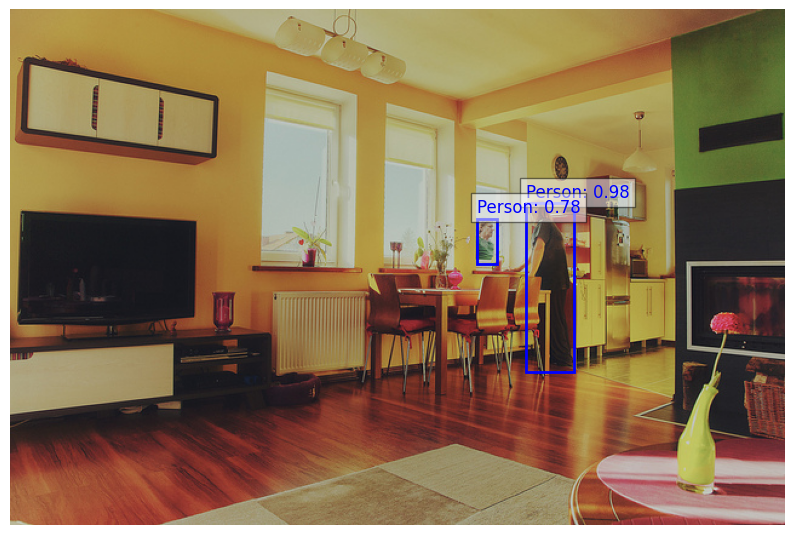

Processed 1/100: 000000000139.jpg
Visualizing prediction for 000000000785.jpg...


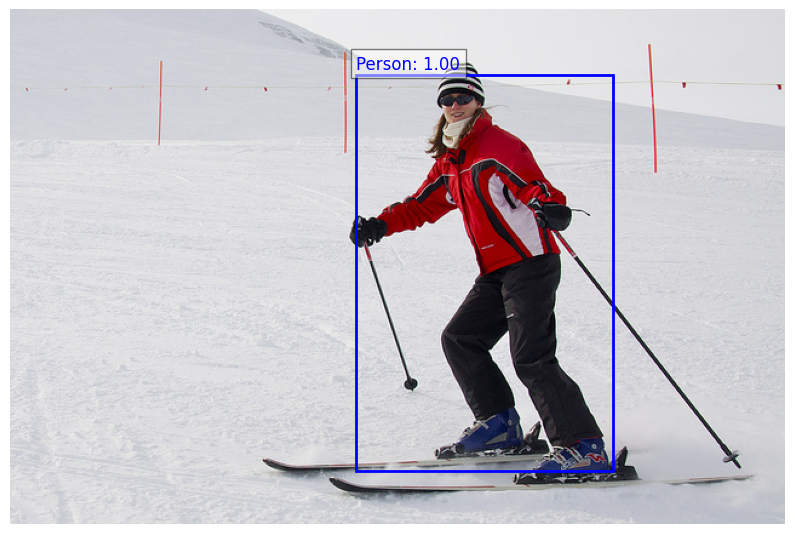

Processed 2/100: 000000000785.jpg
Visualizing prediction for 000000000872.jpg...


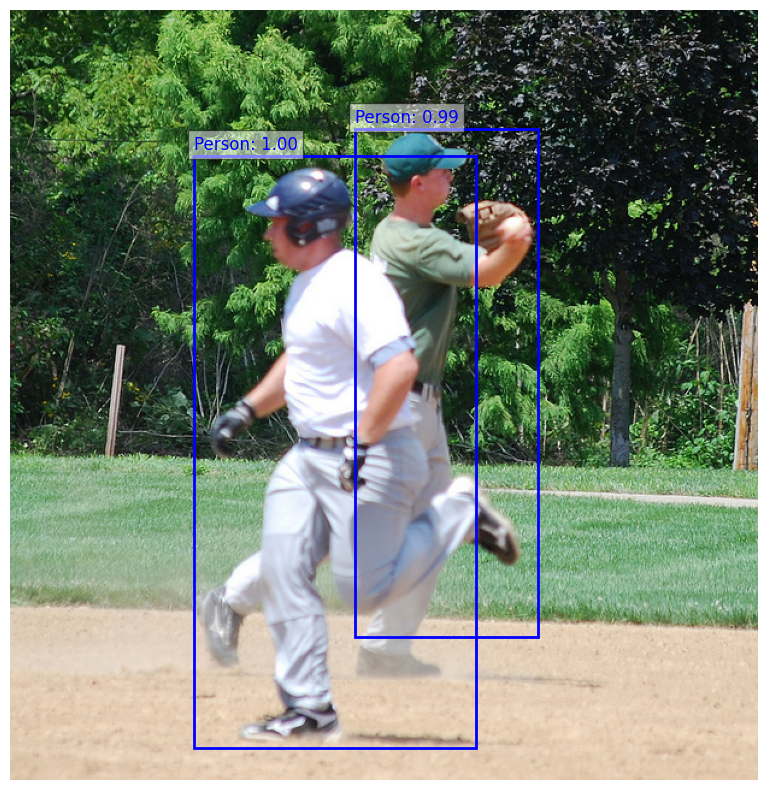

Processed 3/100: 000000000872.jpg
Processed 4/100: 000000000885.jpg
Processed 5/100: 000000001000.jpg
Processed 6/100: 000000001268.jpg
Processed 7/100: 000000001296.jpg
Processed 8/100: 000000001353.jpg
Processed 9/100: 000000001490.jpg
Processed 10/100: 000000001584.jpg
Processed 11/100: 000000001761.jpg
Processed 12/100: 000000002006.jpg
Processed 13/100: 000000002153.jpg
Processed 14/100: 000000002261.jpg
Processed 15/100: 000000002299.jpg
Processed 16/100: 000000002431.jpg
Processed 17/100: 000000002473.jpg
Processed 18/100: 000000002532.jpg
Processed 19/100: 000000002685.jpg
Processed 20/100: 000000003156.jpg
Processed 21/100: 000000003255.jpg
Processed 22/100: 000000003553.jpg
Processed 23/100: 000000003934.jpg
Processed 24/100: 000000004134.jpg
Processed 25/100: 000000004395.jpg
Processed 26/100: 000000004765.jpg
Processed 27/100: 000000005001.jpg
Processed 28/100: 000000005037.jpg
Processed 29/100: 000000005060.jpg
Processed 30/100: 000000005193.jpg
Processed 31/100: 000000005

In [ ]:
import os
import time
import json
import torch
from PIL import Image
import torchvision.transforms.functional as F
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.ops.boxes import box_iou
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch
from torchvision.ops.boxes import box_iou
from sklearn.metrics import average_precision_score

model_frcnn = fasterrcnn_resnet50_fpn(pretrained=True).to(device)

model_frcnn.eval()  # Set the model to evaluation mode first (to prevent changes to pre-trained weights)


# Daftar kelas COCO
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
    'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack',
    'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet',
    'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

# Fungsi untuk mendeteksi objek hanya "person"
def detect_person_frcnn(image_path):
    image = Image.open(image_path).convert("RGB")

    # Preprocessing
    image_tensor = F.to_tensor(image).to(device)

    # Inference
    with torch.no_grad():
        predictions = model_frcnn([image_tensor])

    # Filter hasil prediksi hanya untuk label "person" (label = 1)
    person_predictions = {
        "boxes": [],
        "scores": [],
        "labels": []
    }
    for box, score, label in zip(predictions[0]['boxes'], predictions[0]['scores'], predictions[0]['labels']):
        if label == 1 and score > 0.5:  # Label "person" dan skor > 0.5
            person_predictions["boxes"].append(box)
            person_predictions["scores"].append(score)
            person_predictions["labels"].append(label)

    # Konversi ke tensor
    person_predictions["boxes"] = torch.stack(person_predictions["boxes"]) if person_predictions["boxes"] else torch.tensor([])
    person_predictions["scores"] = torch.tensor(person_predictions["scores"])
    person_predictions["labels"] = torch.tensor(person_predictions["labels"])

    return person_predictions, image  # Mengembalikan prediksi dan gambar asli

# Fungsi untuk menampilkan hasil prediksi
def plot_predictions(image, predictions):
    """Visualisasi hasil prediksi."""
    plt.figure(figsize=(10, 10))
    plt.imshow(image)

    # Jika ada prediksi, gambarkan bounding box
    for box, score in zip(predictions["boxes"], predictions["scores"]):
        coords = box.cpu().numpy()
        x1, y1, x2, y2 = coords
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='blue', facecolor='none')
        plt.gca().add_patch(rect)
        plt.text(x1, y1 - 5, f'Person: {score:.2f}', color='blue', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

    plt.axis('off')
    plt.show()

# Path folder COCO val2017
val2017_path = "val2017"  # Ubah ke path folder val2017 Anda
annotations_path = "annotations/instances_val2017.json"  # File JSON ground truth COCO

# Load ground truth COCO
with open(annotations_path, "r") as f:
    coco_data = json.load(f)

# Fungsi untuk mendapatkan ground truth dari file JSON COCO
def get_ground_truth(coco_data, image_id):
    annotations = [ann for ann in coco_data["annotations"] if ann["image_id"] == image_id and ann["category_id"] == 1]  # Hanya ambil "person"
    boxes = []
    labels = []
    for ann in annotations:
        bbox = ann["bbox"]
        # COCO format bbox [x, y, width, height] -> [x1, y1, x2, y2]
        x1, y1, w, h = bbox
        x2 = x1 + w
        y2 = y1 + h
        boxes.append([x1, y1, x2, y2])
        labels.append(ann["category_id"])
    return {"boxes": torch.tensor(boxes, dtype=torch.float32), "labels": torch.tensor(labels)}

# Dapatkan daftar file gambar yang mengandung "person"
image_files_with_person = []
for image in coco_data["images"]:
    image_id = image["id"]
    # Cek apakah gambar ini mengandung anotasi "person"
    has_person = any(ann["category_id"] == 1 for ann in coco_data["annotations"] if ann["image_id"] == image_id)
    if has_person:
        image_files_with_person.append(image["file_name"])

# Ambil hanya 100 gambar yang mengandung "person"
image_files = sorted(image_files_with_person)[:100] # Batasi hanya 100 gambar
predictions = []
ground_truths = []

# Prediksi pada 500 gambar
for idx, image_file in enumerate(image_files):
    image_path = os.path.join(val2017_path, image_file)
    image_id = int(image_file.split(".")[0])  # Asumsi nama file adalah ID gambar

    # Deteksi objek
    pred, image = detect_person_frcnn(image_path)
    predictions.append(pred)
    # Ambil ground truth
    gt = get_ground_truth(coco_data, image_id)
    ground_truths.append(gt)

    # Visualisasi hanya untuk 3 gambar pertama
    if idx < 3:
        print(f"Visualizing prediction for {image_file}...")
        plot_predictions(image, pred)

    print(f"Processed {idx + 1}/{len(image_files)}: {image_file}")

def evaluate_person_predictions(predictions, ground_truths, iou_threshold=0.5):
    """
    Menghitung Precision dan Recall untuk label "person" (label = 1).
    predictions: daftar prediksi (list of dicts dengan 'boxes', 'scores', dan 'labels')
    ground_truths: daftar ground truth (list of dicts dengan 'boxes' dan 'labels')
    """
    total_true_positives = 0
    total_false_positives = 0
    total_ground_truths = 0

    for pred, gt in zip(predictions, ground_truths):
        # Ambil hanya ground truth untuk "person"
        gt_boxes = gt["boxes"][gt["labels"] == 1]
        gt_labels = gt["labels"][gt["labels"] == 1]

        pred_boxes = pred["boxes"]
        pred_scores = pred["scores"]
        pred_labels = pred["labels"]

        gt_boxes = gt_boxes.to(device)
        # Hitung IoU antara prediksi dan ground truth
        if len(pred_boxes) > 0 and len(gt_boxes) > 0:
            iou = box_iou(pred_boxes, gt_boxes)
        else:
            iou = torch.tensor([])

        # Match prediksi dan ground truth berdasarkan IoU threshold
        matched_gt = set()
        true_positives = 0
        false_positives = 0

        for i, (box, score, label) in enumerate(zip(pred_boxes, pred_scores, pred_labels)):
            if score < 0.5:  # Hanya hitung prediksi dengan score lebih dari 0.5
                continue

            # Cari ground truth dengan IoU tertinggi untuk prediksi ini
            if len(gt_boxes) > 0:
                iou_values = iou[i]
                max_iou, max_iou_idx = iou_values.max(0)

                if max_iou >= iou_threshold and max_iou_idx.item() not in matched_gt and label == 1:
                    true_positives += 1
                    matched_gt.add(max_iou_idx.item())
                else:
                    false_positives += 1
            else:
                false_positives += 1

        total_true_positives += true_positives
        total_false_positives += false_positives
        total_ground_truths += len(gt_boxes)

    precision = total_true_positives / (total_true_positives + total_false_positives) if (total_true_positives + total_false_positives) > 0 else 0
    recall = total_true_positives / total_ground_truths if total_ground_truths > 0 else 0
    return precision, recall
# Evaluasi hasil
# Jika ground truth tersedia, tambahkan evaluasi mAP atau Precision-Recall
precision, recall = evaluate_person_predictions(predictions, ground_truths)
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}")

# Fungsi untuk menghitung Average Precision (AP) untuk masing-masing gambar
def compute_average_precision(predictions, ground_truths, iou_threshold=0.5):
    """
    Menghitung Average Precision (AP) untuk "person" (label = 1).
    predictions: daftar prediksi (list of dicts dengan 'boxes', 'scores', dan 'labels')
    ground_truths: daftar ground truth (list of dicts dengan 'boxes' dan 'labels')
    """
    all_scores = []
    all_labels = []
    all_detections = []
    all_gt_boxes = []

    for pred, gt in zip(predictions, ground_truths):
        # Ensure ground truth boxes and labels are tensors
        gt_boxes = gt["boxes"]
        gt_labels = gt["labels"]

        # Convert to tensor if they are lists
        if isinstance(gt_boxes, list):
            gt_boxes = torch.tensor(gt_boxes, dtype=torch.float32)
        if isinstance(gt_labels, list):
            gt_labels = torch.tensor(gt_labels, dtype=torch.int64)

        # Handle empty ground truths
        if len(gt_labels) > 0:
            person_indices = gt_labels == 1  # Boolean mask for "person"
            gt_boxes = gt_boxes[person_indices] if len(gt_boxes) > 0 else torch.empty((0, 4))
            gt_labels = gt_labels[person_indices]
        else:
            gt_boxes = torch.empty((0, 4))
            gt_labels = torch.empty(0, dtype=torch.int64)

        # Add predictions
        pred_boxes = pred["boxes"]
        pred_scores = pred["scores"]
        pred_labels = pred["labels"]

        # Store results
        all_gt_boxes.append(gt_boxes)
        all_detections.append(pred_boxes)
        all_scores.append(pred_scores)
        all_labels.append(pred_labels)

    return all_scores, all_labels, all_detections, all_gt_boxes


# Fungsi untuk menghitung mean Average Precision (mAP)
def compute_map(all_scores, all_labels, all_detections, all_gt_boxes, iou_threshold=0.5):
    """
    Menghitung mean Average Precision (mAP) pada dataset.
    """
    # Looping melalui setiap gambar untuk menghitung AP
    precision_list = []
    recall_list = []
    for scores, labels, detections, gt_boxes in zip(all_scores, all_labels, all_detections, all_gt_boxes):
        gt_boxes = gt_boxes.to(device)
        # Sorting berdasarkan confidence score
        sorted_indices = torch.argsort(scores, descending=True)
        sorted_detections = [detections[i] for i in sorted_indices]
        sorted_scores = [scores[i] for i in sorted_indices]
        sorted_labels = [labels[i] for i in sorted_indices]

        tp = np.zeros(len(sorted_detections))
        fp = np.zeros(len(sorted_detections))
        total_gt = len(gt_boxes)

        for idx, det in enumerate(sorted_detections):
            # Check if gt_boxes is empty
            if gt_boxes.nelement() == 0: # if gt_boxes is empty, skip the comparison
                fp[idx] = 1
                continue

            iou_values = box_iou(det.unsqueeze(0), gt_boxes)
            max_iou, max_iou_idx = iou_values.max(0)

            # Check if max_iou is a tensor and get its value if so
            max_iou_value = max_iou.item() if max_iou.numel() == 1 else max_iou.max().item()

            if max_iou_value >= iou_threshold:
                tp[idx] = 1
            else:
                fp[idx] = 1

        # Compute precision and recall
        tp_cumsum = np.cumsum(tp)
        fp_cumsum = np.cumsum(fp)
        # Check if tp_cumsum and fp_cumsum are empty before accessing elements
        if len(tp_cumsum) > 0 and len(fp_cumsum) > 0:
            precision = tp_cumsum / (tp_cumsum + fp_cumsum) if tp_cumsum[-1] + fp_cumsum[-1] > 0 else 0
            recall = tp_cumsum / total_gt if total_gt > 0 else 0
        else:
            precision = 0  # Handle empty cases by setting precision and recall to 0
            recall = 0

        # Check if precision or recall are single values
        if not isinstance(precision, np.ndarray) or precision.ndim == 0:
            precision = np.array([precision]) # Convert to an array if it's a single value
        if not isinstance(recall, np.ndarray) or recall.ndim == 0:
            recall = np.array([recall])

        precision_list.append(precision)
        recall_list.append(recall)

    # Average precision at different recall thresholds
    average_precision_list = []
    for precision, recall in zip(precision_list, recall_list):
        # Use interpolation to calculate AP

        # Check if precision and recall have enough data points for interpolation
        if len(precision) > 1 and len(recall) > 1:
            recall_interp = np.linspace(0, 1, num=11)
            precision_interp = np.interp(recall_interp, recall, precision)
            average_precision = np.mean(precision_interp)
            average_precision_list.append(average_precision)
        else:
            average_precision_list.append(0) # Append 0 if not enough data points for interpolation

    # Mean Average Precision (mAP)
    mAP = np.mean(average_precision_list)

    return mAP

# Dapatkan skor, label, dan kotak prediksi untuk evaluasi mAP
all_scores, all_labels, all_detections, all_gt_boxes = compute_average_precision(predictions, ground_truths)

# Hitung mAP
map_score = compute_map(all_scores, all_labels, all_detections, all_gt_boxes)
print(f"mAP: {map_score:.4f}")





In [ ]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

# File path
val2017_path = "val2017"  # Path folder val2017
annotations_path = "annotations/instances_val2017.json"  # File JSON ground truth COCO

# Load ground truth annotations menggunakan COCO API
coco_gt = COCO(annotations_path)

# Simpan hasil prediksi ke format COCO untuk evaluasi
def convert_to_coco_format(predictions, image_ids):
    """
    Mengonversi prediksi model ke format COCO untuk evaluasi mAP.
    """
    coco_predictions = []
    for image_id, pred in zip(image_ids, predictions):
        boxes = pred["boxes"].cpu().numpy()
        scores = pred["scores"].cpu().numpy()
        labels = pred["labels"].cpu().numpy()

        for box, score, label in zip(boxes, scores, labels):
            x1, y1, x2, y2 = box
            width = x2 - x1
            height = y2 - y1
            coco_predictions.append({
                "image_id": image_id,
                "category_id": int(label),
                "bbox": [float(x1), float(y1), float(width), float(height)],
                "score": float(score)
            })
    return coco_predictions

# Dapatkan ID gambar dari file
image_files = sorted(os.listdir(val2017_path))
image_ids = [int(image_file.split(".")[0]) for image_file in image_files]

# Konversi prediksi ke format COCO
coco_predictions = convert_to_coco_format(predictions, image_ids)

# Simpan prediksi ke file JSON (opsional jika ingin melihat hasilnya)
predictions_path = "predictions.json"
with open(predictions_path, "w") as f:
    json.dump(coco_predictions, f)

# Load prediksi menggunakan COCO API
coco_dt = coco_gt.loadRes(predictions_path)

# Evaluasi mAP menggunakan COCOeval
coco_eval = COCOeval(coco_gt, coco_dt, "bbox")
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

# Output utama
print(f"mAP@[.5:.95]: {coco_eval.stats[0]:.4f}")
print(f"AP at IoU=0.50: {coco_eval.stats[1]:.4f}")
print(f"AP at IoU=0.75: {coco_eval.stats[2]:.4f}")


loading annotations into memory...
Done (t=0.72s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=13.47s).
Accumulating evaluation results...
DONE (t=2.55s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet